In [1]:
import os
import pandas as pd
import numpy as np
import re

In [2]:

# Define the project root as the directory containing the notebook, or adjust as needed
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Define the path to the JSON file relative to the project root
json_file_path = os.path.join(PROJECT_ROOT, 'data', 'raw', 'uk_data.json')

# Load the JSON file into a pandas DataFrame
def load_json_as_dataframe(file_path):
    return pd.read_json(file_path, orient='records')

# Load the combined_organizations.json file
combined_organizations = load_json_as_dataframe(json_file_path)

# Now, combined_organizations_df contains the loaded data in a pandas DataFrame
print(combined_organizations.info())  # This will give you an overview of the data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36508 entries, 0 to 36507
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SME                 36508 non-null  object
 1   active              36508 non-null  object
 2   activityType        36508 non-null  object
 3   city                36508 non-null  object
 4   contactForm         36508 non-null  object
 5   contentUpdateDate   36508 non-null  object
 6   country             36508 non-null  object
 7   ecContribution      36508 non-null  object
 8   endOfParticipation  36508 non-null  object
 9   geolocation         36508 non-null  object
 10  name                36508 non-null  object
 11  netEcContribution   36508 non-null  object
 12  nutsCode            36508 non-null  object
 13  order               36508 non-null  int64 
 14  organisationID      36508 non-null  object
 15  organizationURL     36508 non-null  object
 16  postCode            36

In [3]:
combined_organizations.head()

,SME,active,activityType,city,contactForm,contentUpdateDate,country,ecContribution,endOfParticipation,geolocation,...,organizationURL,postCode,projectAcronym,projectID,rcn,role,shortName,street,totalCost,vatNumber
0,,,REC,MOOR ROW,https://ec.europa.eu/info/funding-tenders/oppo...,2016-10-24 10:10:05,UK,175000,False,,...,http://www.nda.gov.uk,CA24 3HU,SECIGD2,323260,1906596,participant,NDA,Westlakes Science PArk - Herdus House,,
1,,,OTH,EXETER,https://ec.europa.eu/info/funding-tenders/oppo...,2019-07-16 20:11:44,UK,81186.23,True,,...,http://www.swtourism.co.uk,EX2 5WT,ERNEST,219438,2123954,participant,South West Tourism,Woodwater Park Pynes Hill,,
2,,,PUB,Cardiff,https://ec.europa.eu/info/funding-tenders/oppo...,2019-07-16 20:11:44,UK,34997,False,"51.4816546,-3.1791934",...,,CF10 3NQ,ERNEST,219438,1915686,participant,Welsh Government,CATHAYS PARK WELSH ASSEMBLY GOVERNMENT,,GB888835056
3,,,PRC,OAKHAM,https://ec.europa.eu/info/funding-tenders/oppo...,2017-05-29 14:50:03,UK,25000,False,,...,http://www.terrasalus.co.uk,LE15 9EL,EBSSYN,226103,2128407,coordinator,TerraSalus,CHURCH LANE 3A,,
4,,,PRC,WESTON HERTS,https://ec.europa.eu/info/funding-tenders/oppo...,2017-12-18 10:13:48,UK,9940,False,,...,,SG4 7DP,INNOVAHEALTH,282558,2168344,participant,Pharmivation,FAIRCLOUGH HALL RED SKY HOUSE,,


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

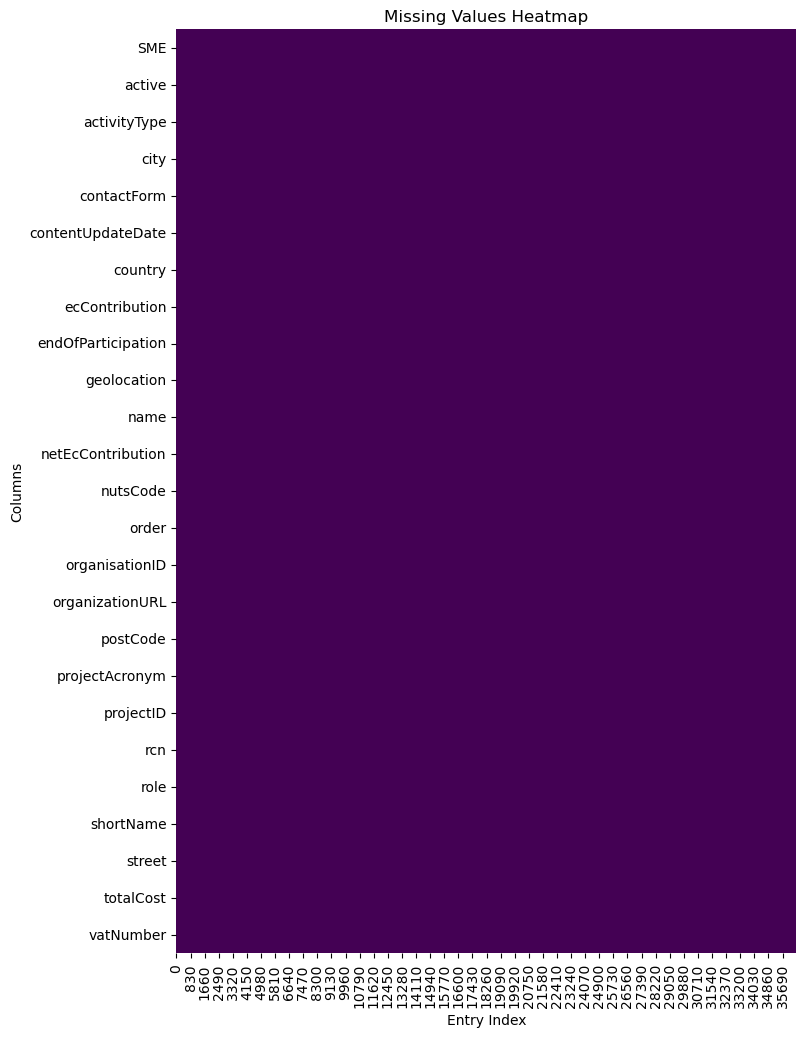

In [5]:
# Heatmap of missing values
plt.figure(figsize=(8, 12))
sns.heatmap(combined_organizations.isnull().T, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.xlabel('Entry Index')
plt.ylabel('Columns')
plt.show()


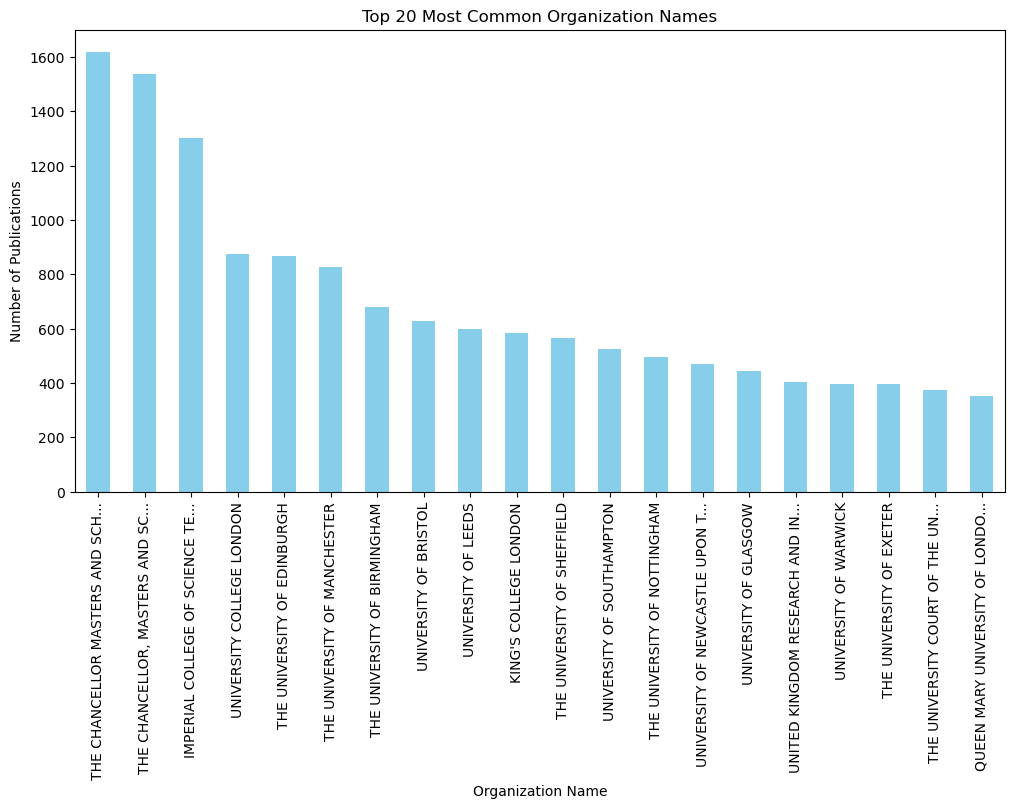

In [6]:
# Truncate long organization names for better readability
def truncate_name(name, length=30):
    name = str(name)  # Convert to string
    if len(name) > length:
        return name[:length] + '...'
    else:
        return name

# Apply truncation to the 'name' column
combined_organizations['short_name'] = combined_organizations['name'].apply(truncate_name)

# Top 20 most common organization names with truncated labels
plt.figure(figsize=(12, 6))
combined_organizations['short_name'].value_counts().head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Common Organization Names')
plt.xlabel('Organization Name')
plt.ylabel('Number of Publications')
plt.xticks(rotation=90)
plt.show()


In [8]:

# Improved standardize function
def standardize_name(name):
    name = str(name).lower()  # Convert to lowercase
    name = re.sub(r'[^\w\s]', '', name)  # Remove punctuation
    name = re.sub(r'\b(limited|inc|ltd|gmbh|sa|co|corporation|corp|llc|plc)\b', '', name)  # Remove common legal entity suffixes
    name = re.sub(r'\b(the|of|and)\b', '', name)  # Remove common connecting words
    name = re.sub(r'\s+', ' ', name).strip()  # Remove extra spaces
    return name

# Apply standardization
combined_organizations['standardized_name'] = combined_organizations['name'].apply(standardize_name)

# Display the first few rows to check the result
combined_organizations[['name', 'standardized_name']].head()


,name,standardized_name
0,NUCLEAR DECOMMISSIONING AUTHORITY - NDA,nuclear decommissioning authority nda
1,SOUTH WEST TOURISM LIMITED,south west tourism
2,WELSH GOVERNMENT,welsh government
3,TERRASALUS LIMITED,terrasalus
4,Ol PHARMA PARTNERS LTD,ol pharma partners


In [9]:
len(combined_organizations['standardized_name'].unique())

5401

In [10]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering

# Sample the data for demonstration purposes
sampled_names = combined_organizations['standardized_name'].sample(n=5000, random_state=42).unique()

# Vectorize the organization names
vectorizer = TfidfVectorizer().fit_transform(sampled_names)

# Perform clustering with the updated metric parameter
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0, metric='cosine', linkage='complete').fit(vectorizer.toarray())

# Assign cluster labels
cluster_labels = clustering.labels_

# Create a DataFrame with the results
clustered_names = pd.DataFrame({'name': sampled_names, 'cluster': cluster_labels})

# Group by clusters to find similar names
grouped_clusters = clustered_names.groupby('cluster')['name'].apply(list).reset_index()

# Filter out clusters with only one organization (i.e., no potential duplicates)
potential_duplicates = grouped_clusters[grouped_clusters['name'].apply(len) > 1]

# Display the first few clusters with potential duplicates
potential_duplicates.head(10)



,cluster,name
0,0,[chancellor masters scholars university oxford...
1,1,"[cancer research uk lbg, trilateral research c..."
2,2,[european centre for mediumrange weather forec...
3,3,"[north west textiles network, f6s network, tax..."
4,4,"[nats en route public company, eli lilly compa..."
5,5,"[uk centre for ecology hydrology, cenex centre..."
6,6,"[francis crick institute, institute developmen..."
7,7,"[queen mary university london, university coll..."
8,8,"[talis systems, micro systems uk, transport sy..."
9,9,[leeds teaching hospitals national health serv...


In [11]:
# Function to visualize clusters
def visualize_clusters(cluster_df, num_clusters=10):
    cluster_df = cluster_df.head(num_clusters)
    for idx, row in cluster_df.iterrows():
        print(f"Cluster {row['cluster']}:")
        for name in row['name']:
            print(f" - {name}")
        print("\n" + "-"*40 + "\n")

# Visualize the top 10 clusters with potential duplicates
visualize_clusters(potential_duplicates, num_clusters=10)


Cluster 0:
 - chancellor masters scholars university oxford
 - university reading
 - university leicester
 - university manchester
 - chancellor masters scholars university cambridge
 - university essex
 - university sussex
 - cardiff university
 - university bristol
 - university gloucestershire
 - coventry university
 - university bath
 - university durham
 - aberystwyth university
 - university nottingham
 - cranfield university
 - university bedfordshire
 - university york
 - bangor university
 - university hull
 - university warwick
 - swansea university
 - university exeter
 - loughborough university
 - university dundee
 - heriotwatt university
 - university lincoln
 - university lancaster
 - university ulster
 - university court university st andrews
 - university court abertay university
 - teesside university
 - university court university aberdeen
 - brighton sussex university hospitals nhs trust
 - nottingham trent university
 - university kent
 - university huddersfield
 -

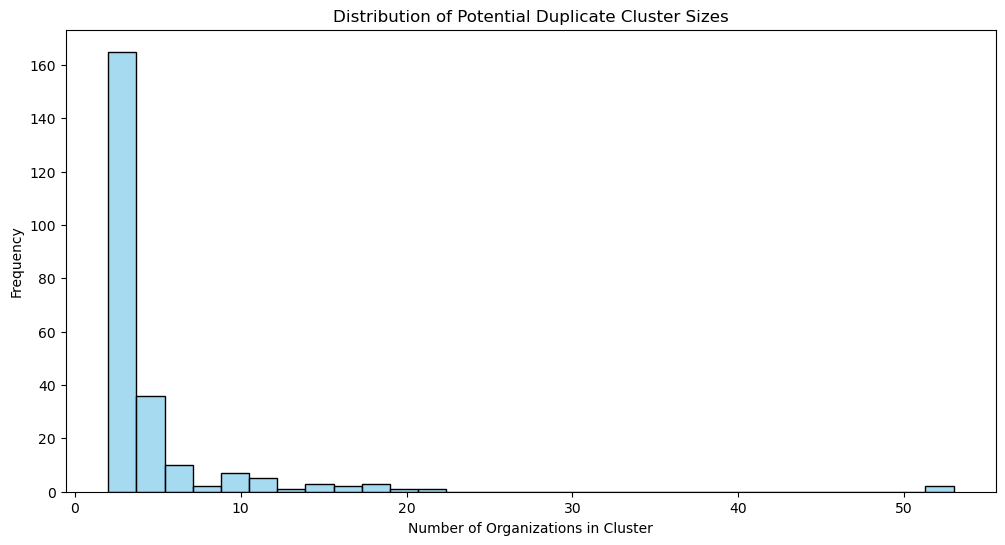

In [12]:
# Plotting the distribution of cluster sizes
plt.figure(figsize=(12, 6))
sns.histplot(potential_duplicates['name'].apply(len), bins=30, kde=False, color='skyblue')
plt.title('Distribution of Potential Duplicate Cluster Sizes')
plt.xlabel('Number of Organizations in Cluster')
plt.ylabel('Frequency')
plt.show()


In [13]:
# Group by 'organisationID' and count the number of unique names
org_name_counts = combined_organizations.groupby('organisationID')['name'].nunique()

# Filter to find organisationIDs with more than one unique name
multiple_names_orgs = org_name_counts[org_name_counts > 1]

# Display the result
multiple_names_orgs = multiple_names_orgs.reset_index()
multiple_names_orgs.columns = ['organisationID', 'unique_name_count']
print(f"Number of organisationIDs with more than one unique name: {len(multiple_names_orgs)}")
multiple_names_orgs.head(10)


Number of organisationIDs with more than one unique name: 1


,organisationID,unique_name_count
0,,43
